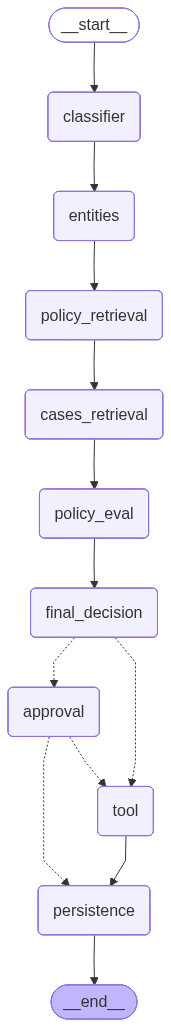

🔔 Approval needed. (Demo auto-approves if 'filesystem_extension' on prod)
🛠️  Tool Node executing: request_approval


ValueError: Expected metadata value to be a str, int, float, bool, or None, got {'label': 'Task', 'confidence': 92} which is a dict in add.

In [2]:
# workflow.py
from __future__ import annotations
from typing import TypedDict, Dict, List, Any, Callable
from dataclasses import dataclass, field
from pathlib import Path
import json, sqlite3, os
from datetime import datetime
from IPython.display import Image, display

# --- LangGraph ---
from langgraph.graph import StateGraph, END

# --- Vector DB (Chroma) + Embeddings (OpenAI) ---
import chromadb
from openai import OpenAI

# =========================
# CONFIG
# =========================
DB_PATH = "agent_memory.sqlite"
CHROMA_DIR = "chroma_store"
POLICY_COLLECTION = "policies"
CASES_COLLECTION = "email_cases"

# If you don't want to hit the API during dev, set DEMO_MODE=True
DEMO_MODE = True

# =========================
# STATE
# =========================
class EmailState(TypedDict, total=False):
    email_text: str
    classification: Dict[str, Any]         # {"label": ..., "confidence": ...}
    entities: Dict[str, Dict[str, Any]]    # {"server": {"value":..., "confidence":...}, ...}
    retrieved_policies: List[Dict[str, Any]]  # [{"text":..., "similarity":...}, ...]
    retrieved_cases: List[Dict[str, Any]]     # [{"text":..., "similarity":..., "metadata":{...}}, ...]
    policy_eval: Dict[str, Any]            # {"requires_approval": bool, "confidence": ...}
    final_decision: Dict[str, Any]         # {"action": "...", "confidence": ...}
    approval_result: str                   # "yes" / "no" / None

# =========================
# LLM WRAPPER (swap in your own)
# =========================
@dataclass
class LLMWrapper:
    client: Any = field(default=None)  # OpenAI() if not DEMO
    model: str = "gpt-4o-mini"

    def classify_email(self, text: str) -> Dict[str, Any]:
        if DEMO_MODE:
            label = "Task" if "please" in text.lower() or "extend" in text.lower() else ("Alert" if "alert" in text.lower() else ("Query" if "?" in text else "Informational"))
            conf = 92 if label in ("Task","Alert") else 85
            return {"classification": label, "confidence": conf}
        # real call (example)
        msg = [
            {"role":"system","content":"Classify as one of: Alert, Informational, Task, Query. Return JSON with keys classification, confidence (0-100)."},
            {"role":"user","content":text}
        ]
        r = self.client.chat.completions.create(model=self.model, messages=msg, response_format={"type":"json_object"})
        return json.loads(r.choices[0].message.content)

    def extract_entities(self, text: str, inventory: List[str]) -> Dict[str, Dict[str, Any]]:
        if DEMO_MODE:
            found_server = next((s for s in inventory if s.lower() in text.lower()), None)
            entities = {}
            if found_server:
                entities["server"] = {"value": found_server, "confidence": 95}
                env = "prod" if "prod" in found_server.lower() or "prod" in text.lower() else "test"
                entities["environment"] = {"value": env, "confidence": 90}
            if "inc" in text.lower():
                # naive ticket detection
                import re
                m = re.search(r"(INC|SR)\s*[-:]?\s*\d+", text, re.I)
                if m: entities["ticket"] = {"value": m.group(0).replace(" ", ""), "confidence": 88}
            if "extend" in text.lower():
                entities["action_type"] = {"value": "filesystem_extension", "confidence": 93}
            return entities
        # real call (example)
        schema = 'Return JSON like {"server":{"value":"...","confidence":..}, "environment":{"value":"prod|test","confidence":..}, "ticket":{"value":"...","confidence":..}, "action_type":{"value":"...","confidence":..}}.'
        msg = [
            {"role":"system","content":f"Extract entities from email. Server must be from this inventory: {inventory}. {schema}"},
            {"role":"user","content":text}
        ]
        r = self.client.chat.completions.create(model=self.model, messages=msg, response_format={"type":"json_object"})
        return json.loads(r.choices[0].message.content)

    def evaluate_policies(self, text: str, policy_snippets: List[str], similar_cases: List[Dict[str, Any]]) -> Dict[str, Any]:
        if DEMO_MODE:
            needs = any("filesystem" in s.lower() and "approval" in s.lower() for s in policy_snippets) or ("filesystem" in text.lower() and "prod" in text.lower())
            return {"requires_approval": bool(needs), "confidence": 87 if needs else 80}
        cases_str = "\n".join([f"- {c['text'][:300]}" for c in similar_cases])
        pol_str = "\n".join([f"- {p}" for p in policy_snippets])
        msg = [
            {"role":"system","content":"Decide if action requires approval. Return JSON {\"requires_approval\": bool, \"confidence\": int}."},
            {"role":"user","content":f"Email:\n{text}\n\nPolicies:\n{pol_str}\n\nSimilar past cases:\n{cases_str}"}
        ]
        r = self.client.chat.completions.create(model=self.model, messages=msg, response_format={"type":"json_object"})
        return json.loads(r.choices[0].message.content)

# =========================
# STORAGE: SQL + VECTOR
# =========================
class Storage:
    def __init__(self, db_path=DB_PATH, chroma_dir=CHROMA_DIR, openai_client: Any | None = None):
        # SQL
        self.conn = sqlite3.connect(db_path)
        self.cur = self.conn.cursor()
        self._ensure_sql()

        # Vector DB
        os.makedirs(chroma_dir, exist_ok=True)
        self.chroma = chromadb.PersistentClient(path=chroma_dir)

        # Embeddings
        self.oai = openai_client
        self.embed_model = "text-embedding-3-small"

        # collections
        self.policies = self.chroma.get_or_create_collection(POLICY_COLLECTION)
        self.cases = self.chroma.get_or_create_collection(CASES_COLLECTION)

    def _ensure_sql(self):
        self.cur.execute("""
        CREATE TABLE IF NOT EXISTS email_events (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            email_text TEXT,
            classification TEXT,
            entities TEXT,
            retrieved_policies TEXT,
            retrieved_cases TEXT,
            policy_eval TEXT,
            final_decision TEXT,
            approval_result TEXT,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
        """)
        self.conn.commit()

    # -- Embedding helper
    def embed(self, texts: List[str]) -> List[List[float]]:
        if DEMO_MODE:
            # Fake embeddings: consistent hash-based vector (ok for demo similarity)
            import random
            random.seed(42)
            return [[hash(t) % 997 / 997.0 for _ in range(256)] for t in texts]
        resp = self.oai.embeddings.create(model=self.embed_model, input=texts)
        return [d.embedding for d in resp.data]

    # -- Save policy docs (one-time or as needed)
    def upsert_policies(self, policy_texts: List[str]):
        ids = [f"policy-{i}" for i,_ in enumerate(policy_texts)]
        embs = self.embed(policy_texts)
        # Chroma will upsert if ids exist; if not, add
        # Simpler path: delete & add
        try:
            self.policies.delete(ids=ids)
        except Exception:
            pass
        self.policies.add(documents=policy_texts, embeddings=embs, ids=ids)

    # -- Retrieve policies
    def retrieve_policies(self, query: str, k=4) -> List[Dict[str, Any]]:
        embs = self.embed([query])[0]
        res = self.policies.query(query_embeddings=[embs], n_results=k)
        out = []
        for doc, dist in zip(res["documents"][0], res["distances"][0]):
            out.append({"text": doc, "similarity": float(1.0 - dist)})  # convert distance to similarity-ish
        return out

    # -- Save case (email event) to vector DB
    def add_case(self, text: str, metadata: Dict[str, Any], case_id: str):
        embs = self.embed([text])
        self.cases.add(documents=[text], embeddings=embs, metadatas=[metadata], ids=[case_id])

    # -- Retrieve similar past cases
    def retrieve_cases(self, query: str, k=4) -> List[Dict[str, Any]]:
        embs = self.embed([query])[0]
        res = self.cases.query(query_embeddings=[embs], n_results=k)
        out = []
        for doc, md, dist in zip(res["documents"][0], res["metadatas"][0], res["distances"][0]):
            out.append({"text": doc, "similarity": float(1.0 - dist), "metadata": md})
        return out

    # -- Persist full state to SQL and return row id
    def save_state_sql(self, state: EmailState) -> int:
        self.cur.execute("""
            INSERT INTO email_events (email_text, classification, entities, retrieved_policies, retrieved_cases, policy_eval, final_decision, approval_result)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            state.get("email_text",""),
            json.dumps(state.get("classification",{})),
            json.dumps(state.get("entities",{})),
            json.dumps(state.get("retrieved_policies",[])),
            json.dumps(state.get("retrieved_cases",[])),
            json.dumps(state.get("policy_eval",{})),
            json.dumps(state.get("final_decision",{})),
            state.get("approval_result")
        ))
        self.conn.commit()
        return int(self.cur.lastrowid)

# =========================
# NODES
# =========================
# You can pass these closures the dependencies (llm, storage, inventory)
def make_classifier_node(llm: LLMWrapper):
    def node(state: EmailState) -> EmailState:
        res = llm.classify_email(state["email_text"])
        state["classification"] = {"label": res["classification"], "confidence": res.get("confidence",0)}
        return state
    return node

def make_entities_node(llm: LLMWrapper, inventory: List[str]):
    def node(state: EmailState) -> EmailState:
        ents = llm.extract_entities(state["email_text"], inventory)
        state["entities"] = ents
        return state
    return node

def make_policy_retrieval_node(storage: Storage):
    def node(state: EmailState) -> EmailState:
        # Build a short policy query from intent/entities
        action = state.get("entities",{}).get("action_type",{}).get("value") or state["classification"]["label"]
        query = f"policy for {action}"
        hits = storage.retrieve_policies(query, k=4)
        state["retrieved_policies"] = hits
        return state
    return node

def make_cases_retrieval_node(storage: Storage):
    def node(state: EmailState) -> EmailState:
        # Use email_text as query to find similar past cases
        hits = storage.retrieve_cases(state["email_text"], k=4)
        state["retrieved_cases"] = hits
        return state
    return node

def make_policy_eval_node(llm: LLMWrapper):
    def node(state: EmailState) -> EmailState:
        policy_snippets = [p["text"] for p in state.get("retrieved_policies",[])]
        similar_cases = state.get("retrieved_cases",[])
        res = llm.evaluate_policies(state["email_text"], policy_snippets, similar_cases)
        state["policy_eval"] = {"requires_approval": bool(res["requires_approval"]), "confidence": res.get("confidence",0)}
        return state
    return node

def final_decision_node(state: EmailState) -> EmailState:
    # Combine confidences (simple min rule)
    cls_c = state["classification"].get("confidence",100)
    ent_c = min([e.get("confidence",100) for e in state.get("entities",{}).values()] or [100])
    pol_c = state["policy_eval"].get("confidence",100)
    final_conf = min(cls_c, ent_c, pol_c)

    if state["policy_eval"]["requires_approval"]:
        action = "request_approval"
    elif state["classification"]["label"] == "Alert":
        action = "trigger_alert_tool"
    else:
        action = "auto_process_tool"

    state["final_decision"] = {"action": action, "confidence": final_conf}
    return state

def make_approval_node(get_approval: Callable[[EmailState], str]):
    """
    get_approval: function that returns "yes" or "no"
    """
    def node(state: EmailState) -> EmailState:
        # Only called when final_decision requested approval
        result = get_approval(state)  # "yes" / "no"
        state["approval_result"] = result
        return state
    return node

def tool_node(state: EmailState) -> EmailState:
    # Perform the tool action (placeholder)
    action = state["final_decision"]["action"]
    print(f"🛠️  Tool Node executing: {action}")
    return state

def make_persistence_node(storage: Storage):
    def node(state: EmailState) -> EmailState:
        # Save to SQL
        row_id = storage.save_state_sql(state)
        # Save to cases vector DB for future retrieval
        text = state["email_text"]
        metadata = {
            "classification": state.get("classification",{}),
            "entities": state.get("entities",{}),
            "final_decision": state.get("final_decision",{}),
            "approval_result": state.get("approval_result")
        }
        storage.add_case(text=text, metadata=metadata, case_id=f"case-{row_id}")
        print(f"📦 Persisted event row_id={row_id} (SQL) and vector case case-{row_id}")
        return state
    return node

# =========================
# WORKFLOW BUILDER
# =========================
def build_workflow(llm: LLMWrapper, storage: Storage, inventory: List[str], get_approval: Callable[[EmailState], str]):
    wf = StateGraph(EmailState)

    wf.add_node("classifier", make_classifier_node(llm))
    wf.add_node("entities", make_entities_node(llm, inventory))
    wf.add_node("policy_retrieval", make_policy_retrieval_node(storage))
    wf.add_node("cases_retrieval", make_cases_retrieval_node(storage))  # <--- similar past cases
    wf.add_node("policy_eval", make_policy_eval_node(llm))
    wf.add_node("final_decision", final_decision_node)
    wf.add_node("approval", make_approval_node(get_approval))
    wf.add_node("tool", tool_node)
    wf.add_node("persistence", make_persistence_node(storage))

    wf.set_entry_point("classifier")
    wf.add_edge("classifier", "entities")
    wf.add_edge("entities", "policy_retrieval")
    wf.add_edge("policy_retrieval", "cases_retrieval")   # <--- new step
    wf.add_edge("cases_retrieval", "policy_eval")
    wf.add_edge("policy_eval", "final_decision")

    # Branch at final decision:
    def branch_after_final(state: EmailState):
        return "approval" if state["final_decision"]["action"] == "request_approval" else "tool"
    wf.add_conditional_edges("final_decision", branch_after_final, {
        "approval": "approval",
        "tool": "tool"
    })

    # Approval YES/NO branching:
    def branch_after_approval(state: EmailState):
        return "tool" if state.get("approval_result") == "yes" else "persistence"
    wf.add_conditional_edges("approval", branch_after_approval, {
        "tool": "tool",
        "persistence": "persistence"
    })

    # Tool → Persistence → END
    wf.add_edge("tool", "persistence")
    wf.add_edge("persistence", END)

    return wf.compile()

# =========================
# DEMO / MAIN
# =========================
def main():
    # Setup OpenAI and Storage
    oai = None if DEMO_MODE else OpenAI()
    llm = LLMWrapper(client=oai)
    storage = Storage(openai_client=oai)

    # Seed some example policies (idempotent)
    storage.upsert_policies([
        "Policy: Any request to extend a filesystem requires customer approval.",
        "Policy: Any action on production servers requires customer approval.",
        "Policy: Automated restarts on test/dev are allowed without approval.",
        "Policy: Changes affecting data retention must be reviewed by customer."
    ])

    # Simple inventory
    inventory = ["prod-db01", "test-web-01", "prod-app-02"]

    # Approval callback (replace with real UI/Slack/Email flow later)
    def get_approval(state: EmailState) -> str:
        print("🔔 Approval needed. (Demo auto-approves if 'filesystem_extension' on prod)")
        ents = state.get("entities",{})
        action = ents.get("action_type",{}).get("value")
        env = ents.get("environment",{}).get("value")
        return "yes" if (action == "filesystem_extension" and env == "prod") else "no"

    graph = build_workflow(llm, storage, inventory, get_approval)
    display(Image(graph.get_graph().draw_mermaid_png()))


    # Example email
    email_text = """Subject: Extend /home on prod-db01
Please extend /home filesystem on prod-db01 by 20GB. Ticket INC-12345.
"""
    init_state: EmailState = {"email_text": email_text}
    final_state = graph.invoke(init_state)

    print("\n=== FINAL STATE ===")
    print(json.dumps(final_state, indent=2))

if __name__ == "__main__":
    main()
